In [37]:
import cv2
import pytesseract
from pytesseract import Output
import re
import matplotlib.pyplot as plt

#if TesseractNotFoundError occurs
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\ammar.jamalludin\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'

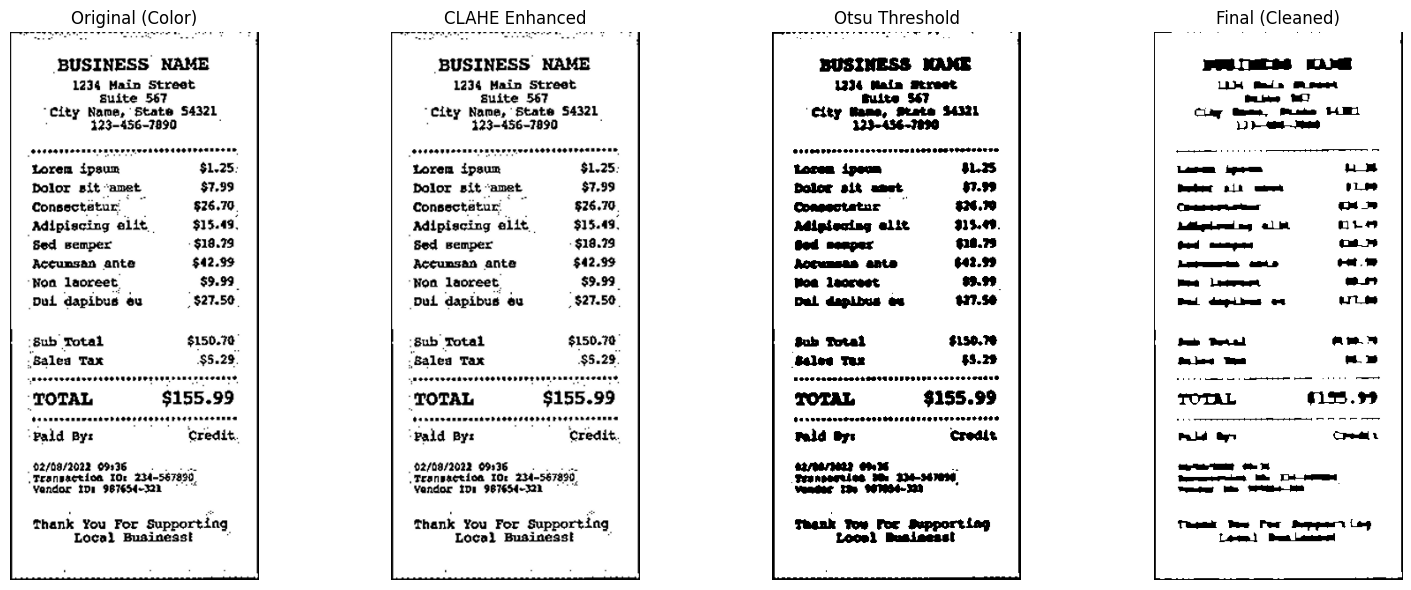

In [38]:
image_path = "result.png"
image = cv2.imread(image_path)
image = cv2.resize(image, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_CUBIC)

# Keep original color copy for display
image_color = image.copy()

# --- Convert to gray and denoise ---
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Non-local means denoising (works well for text images)
denoised = cv2.fastNlMeansDenoising(gray, h=10)

# --- Contrast enhancement (CLAHE) ---
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced = clahe.apply(denoised)

# --- Thresholding (Otsu + adaptive as alternatives) ---
blur = cv2.GaussianBlur(enhanced, (5, 5), 0)
otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
adaptive = cv2.adaptiveThreshold(enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY, 11, 2)

# Ensure text is dark on light background (pytesseract prefers this)
white_ratio = (otsu == 255).mean()
if white_ratio < 0.5:
    otsu = cv2.bitwise_not(otsu)

# --- Morphological clean-up ---
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
clean = cv2.morphologyEx(otsu, cv2.MORPH_OPEN, kernel, iterations=1)
clean = cv2.morphologyEx(clean, cv2.MORPH_CLOSE, kernel, iterations=1)
# Slight dilation to strengthen characters
clean = cv2.dilate(clean, kernel, iterations=1)

final = clean

# Show intermediate and final results side-by-side
fig, axes = plt.subplots(1, 4, figsize=(16, 6))
axes[0].imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original (Color)')
axes[0].axis('off')

axes[1].imshow(enhanced, cmap='gray')
axes[1].set_title('CLAHE Enhanced')
axes[1].axis('off')

axes[2].imshow(otsu, cmap='gray')
axes[2].set_title('Otsu Threshold')
axes[2].axis('off')

axes[3].imshow(final, cmap='gray')
axes[3].set_title('Final (Cleaned)')
axes[3].axis('off')

plt.tight_layout()
plt.show()

# Prepare final image for OCR
final_rgb = cv2.cvtColor(final, cv2.COLOR_GRAY2RGB)


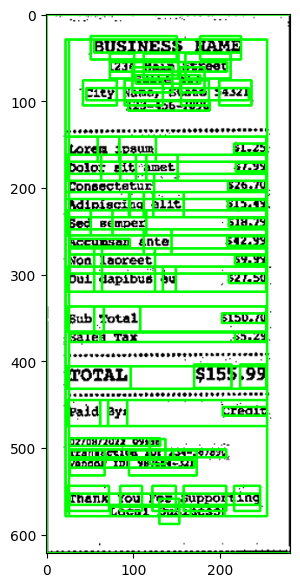

In [39]:
d = pytesseract.image_to_data(final_rgb, output_type=Output.DICT, config='--psm 6')
n_boxes = len(d['level'])
boxes = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])    
    boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
plt.figure(figsize=(14,7))
plt.imshow(cv2.cvtColor(boxes, cv2.COLOR_BGR2RGB))

In [40]:
# OCR on the cleaned image
textConverted = pytesseract.image_to_string(final_rgb, config='--psm 6')
textConverted = re.sub(r'[^\x00-\x7F]+|\x0c', ' ', textConverted)

print(textConverted)


rete Ce
LM ale meet
abe ta?
Chey tae, tee HLL
re)
La pee, ns
Dente Lt cme 1
Comoe on
eager. ous 01h ave
Od gene an
a oe Coed
ot Let on
Pel depts on oles
baie Boned ann
i  
TOTAL ns .99
Pld Oy mete
a
  ke Oe
  eee
 Teen Dame Pear Seapepaear Len
Letom} Bom mtd

